In [37]:
# 下载数据集
import numpy as np
from d2l import torch as d2l
from torch import nn
import torch
import pandas as pd
import hashlib
import os
import tarfile
import zipfile
import requests

data_hub = dict()
data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/'


def download(name, cache_dir=os.path.join('..', 'house_price_data')):
    assert name in data_hub, f"{name}不存在于{data_hub}"
    url, sha1_hash = data_hub[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.join(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():
    for name in data_hub:
        download(name)



In [38]:
# ----------------------------
# 正式开始训练


data_hub['kaggle_house_train'] = (data_url + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')
data_hub['kaggle_house_test'] = (
    data_url + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 标准化和处理na（用0填充）
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# one-hot编码离散数据
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(
    all_features[n_train:].values, dtype=torch.float32)
print(train_data.SalePrice.values.shape)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
print(train_data.SalePrice.values.shape)

loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256),nn.ReLU(),nn.Linear(256,1))
    return net

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
(2919, 331)
(1460,)
(1460,)


折1,训练log rmse0.072174， 验证log rmse0.123630
折2,训练log rmse0.068424， 验证log rmse0.148883
折3,训练log rmse0.067527， 验证log rmse0.140137
折4,训练log rmse0.073797， 验证log rmse0.105589
折5,训练log rmse0.066552， 验证log rmse0.148829
5-折验证: 平均训练log rmse: 0.069695,  平均验证log rmse: 0.133413


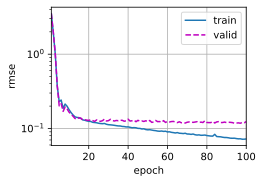

In [39]:

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


def train(
        net,
        train_features,
        train_labels,
        test_features,
        test_labels,
        num_epochs,
        learning_rate,
        weight_decay,
        batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# k-fold validation
def get_k_fold_data(k,i,X,y):
	assert k>1
	fold_size=X.shape[0]//k
	X_train,y_train=None,None
	for j in range(k):
		idx=slice(j*fold_size,(j+1)*fold_size)
		X_part,y_part=X[idx,:],y[idx]
		if j==i:
			x_valid,y_valid=X_part,y_part
		elif X_train is None:
			X_train,y_train=X_part,y_part
		else:
			X_train=torch.cat([X_train,X_part],0)
			y_train=torch.cat([y_train,y_part],0)
	return X_train,y_train,x_valid,y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
	train_l_sum,valid_l_sum=0,0
	for i in range(k):
		data=get_k_fold_data(k,i,X_train,y_train)
		net=get_net()
		train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
		train_l_sum+=train_ls[-1]
		valid_l_sum+=valid_ls[-1]
		if i==0:
			d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
		print(f'折{i+1},训练log rmse{float(train_ls[-1]):f}，',f'验证log rmse{float(valid_ls[-1]):f}')
	return train_l_sum/k,valid_l_sum/k

# 选择模型
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 35, 128
train_l, valid_l = k_fold(k, train_features, train_labels,
                          num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, ',
      f'平均验证log rmse: {float(valid_l):f}')


训练log rmse：0.063391


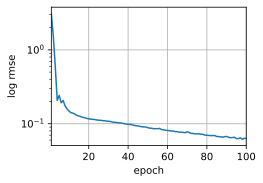

In [40]:

# 训练及提交预测
def train_and_pred(
        train_features,
        test_features,
        train_labels,
        test_data,
        num_epochs,
        lr,
        weight_decay,
        batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels,
                        None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission2.csv', index=False)


train_and_pred(
    train_features,
    test_features,
    train_labels,
    test_data,
    num_epochs,
    lr,
    weight_decay,
    batch_size)